In [82]:
import torch
import gc
import easydict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

import hyperopt
from hyperopt import pyll, hp, fmin, tpe, STATUS_OK, Trials

In [83]:
# !pip install -q hyperopt
# !pip install -q easydict

In [84]:
### ratio 0.9
data = pd.read_csv('opt_metadata.csv', index_col=0)
data

,bert,lstm,last_query,lstm_attn,saint,y
0,0.227665,0.033894,0.078204,0.076432,0.103042,0
1,0.962192,0.846531,0.952949,0.882752,0.934738,1
2,0.124927,0.023707,0.004816,0.029667,0.060086,0
3,0.677230,0.554693,0.603421,0.578528,0.447459,1
4,0.662673,0.314070,0.337882,0.599516,0.189820,0
...,...,...,...,...,...,...
6023,0.322990,0.259768,0.565327,0.395470,0.573913,1
6024,0.863316,0.892938,0.844286,0.893640,0.904047,1
6025,0.903101,0.622870,0.967828,0.812565,0.697296,1
6026,0.122226,0.467528,0.295091,0.385376,0.186934,0


In [85]:
def trials_to_df(trials, space, best):
    # 전체 결과
    rows = []
    keys = list(trials.trials[0]["misc"]["vals"].keys())

    # 전체 실험결과 저장
    for trial in trials:
        row = {}

        # tid
        tid = trial["tid"]
        row["experiment"] = str(tid)

        # hyperparameter 값 저장
        vals = trial["misc"]["vals"]
        hparam = {key: value[0] for key, value in vals.items()}

        # space가 1개 - 값을 바로 반환
        # space가 다수 - dict에 값을 반환
        hparam = hyperopt.space_eval(space, hparam)

        if len(keys) == 1:
            row[keys[0]] = hparam
        else:
            for key in keys:
                row[key] = hparam[key]

        # metric
        row["metric"] = abs(trial["result"]["loss"])

        # 소요 시간
        row["time"] = (trial["refresh_time"] - trial["book_time"]).total_seconds()

        rows.append(row)

    experiment_df = pd.DataFrame(rows)

    # best 실험
    row = {}
    best_hparam = hyperopt.space_eval(space, best)

    if len(keys) == 1:
        row[keys[0]] = best_hparam
    else:
        for key in keys:
            row[key] = best_hparam[key]
    row["experiment"] = "best"

    best_df = pd.DataFrame([row])

    # best 결과의 auc / time searching 하여 찾기
    search_df = pd.merge(best_df, experiment_df, on=keys)

    # column명 변경
    search_df = search_df.drop(columns=["experiment_y"])
    search_df = search_df.rename(columns={"experiment_x": "experiment"})

    # 가장 좋은 metric 결과 중 가장 짧은 시간을 가진 결과를 가져옴
    best_time = search_df.time.min()
    search_df = search_df.query("time == @best_time")

    df = pd.concat([experiment_df, search_df], axis=0)

    return df


In [119]:
X = data.drop(columns=['y']) ; y = data['y']

In [87]:
# 목적 함수
def objective_function(space):
    """
    space 예시 {'batch_size': 64, 'lr': 0.00010810929882981193, 'n_layers': 1}
    """
    # space 가 dict으로 건네지기 때문에 easydict으로 바꿔준다

    global X, y

    # 캐시 메모리 비우기 및 가비지 컬렉터 가동!
    torch.cuda.empty_cache()
    gc.collect()

    space = easydict.EasyDict(space)

    # 하이퍼파라미터 값 변경
    w_bert = space["w_bert"]
    w_lstm = space["w_lstm"]
    w_last_query = space["w_last_query"]
    w_lstm_attn = space["w_lstm_attn"]
    w_saint = space["w_saint"]

    preds = (w_bert * X['bert'] +
             w_lstm * X['lstm'] +
             w_last_query * X['last_query'] +
             w_lstm_attn * X['lstm_attn'] +
             w_saint * X['saint']) / (w_bert + w_lstm + w_last_query + w_lstm_attn + w_saint)
    targets = y

    auc = roc_auc_score(targets, preds)

    return -1 * auc  # 목적 함수 값을 -auc로 설정 => 목적 함수 최소화 => auc 최대화

In [88]:
# 탐색 공간
space = {
    "w_bert": hp.uniform("w_bert", 0, 1),
    "w_lstm": hp.uniform("w_lstm", 0, 1),
    "w_last_query": hp.uniform("w_last_query", 0, 1),
    "w_lstm_attn": hp.uniform("w_lstm_attn", 0, 1),
    "w_saint": hp.uniform("w_saint", 0, 1)}

In [98]:
# 최적화
trials = Trials()
best = fmin(
    fn=objective_function,  # 최적화 할 함수 (목적 함수)
    space=space,  # Hyperparameter 탐색 공간
    algo=tpe.suggest,  # 베이지안 최적화 적용 알고리즘 : Tree-structured Parzen Estimator (TPE)
    max_evals=100,  # 입력 시도 횟수
    trials=trials,  # 시도한 입력 값 및 입력 결과 저장
    rstate=np.random.default_rng(seed=42),  ## fmin()을 시도할 때마다 동일한 결과를 가질 수 있도록 설정하는 랜덤 시드
)

print("best:", best)

# Save
result = trials_to_df(trials, space, best)
result['w_sum'] = result[['w_bert', 'w_last_query', 'w_lstm', 'w_lstm_attn', 'w_saint']].apply(sum, axis=1)
result.sort_values(by="metric", ascending=False, inplace=True)
result.reset_index(drop=True, inplace=True)
result.to_csv("./opt_metadata_result.csv", index=False)

100%|██████████| 100/100 [00:19<00:00,  5.18trial/s, best loss: -0.8084540178136594]
best: {'w_bert': 0.6899933723434534, 'w_last_query': 0.955458450849274, 'w_lstm': 0.8869286268301102, 'w_lstm_attn': 0.9683235519941354, 'w_saint': 0.8942277817959308}


In [99]:
result

,experiment,w_bert,w_last_query,w_lstm,w_lstm_attn,w_saint,metric,time,w_sum
0,best,0.689993,0.955458,0.886929,0.968324,0.894228,0.808454,0.187,4.394932
1,76,0.689993,0.955458,0.886929,0.968324,0.894228,0.808454,0.187,4.394932
2,75,0.681410,0.895035,0.877527,0.969705,0.908000,0.808450,0.176,4.331676
3,81,0.578401,0.905163,0.841262,0.916830,0.885906,0.808436,0.176,4.127561
4,74,0.684928,0.919313,0.873255,0.882664,0.906190,0.808430,0.176,4.266350
...,...,...,...,...,...,...,...,...,...
96,53,0.975372,0.941395,0.172907,0.246633,0.146736,0.805436,0.176,2.483043
97,91,0.652986,0.184100,0.822960,0.052761,0.799861,0.805223,0.176,2.512666
98,14,0.110243,0.973948,0.017097,0.905732,0.232461,0.805160,0.194,2.239480
99,2,0.572728,0.157180,0.617661,0.073661,0.146963,0.804385,0.187,1.568192


In [191]:
sota = pd.read_csv('sota.csv')['prediction']

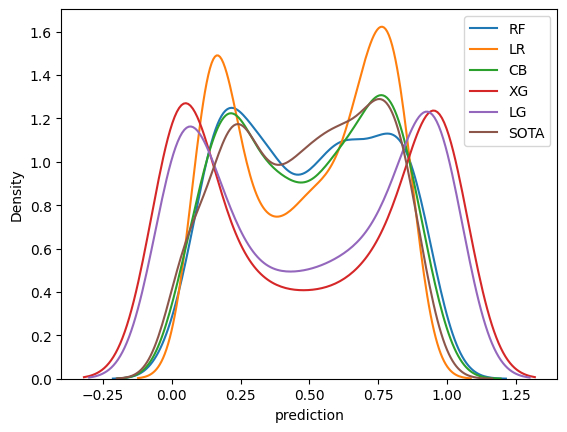

In [192]:
sns.kdeplot(sota, label='SOTA')
plt.legend()
plt.show()